In [12]:
import pandas as pd
import os
import glob
import numpy as np
import Experiments as exp
from itertools import groupby
import seaborn as sns

In [40]:
DB_CSV_PATH = './predictions/database_singlemodel_singlelabel_brats2019v2.csv'
DATABASE = pd.read_csv(DB_CSV_PATH, index_col=0)
OUTPUT_FOLDER = './aggregations_brats2019v2/'

In [8]:
DATABASE = DATABASE.sort_values(by=['dataset', 'modality', 'output_label', 'patient', 'slice'])

In [9]:
LABELS = ['NCR/NET', 'ED', 'ET']
MODALITIES = [ 't1', 't1ce', 't2', 'flair']

# Modality Aggregation
For each Output label, aggregate the four modality models and produce an aggregation to be tested against the ground truth of that label


In [ ]:
AGGREGATION_RESULTS = pd.DataFrame() 
for (test_or_val, output_label), current_dataset in DATABASE.groupby(['dataset', 'output_label']):
    temp = current_dataset.drop(columns=['dataset', 'output_label', 'model_path'])
    temp = temp.set_index(['patient', 'gt_or_pred', 'modality'])
    # Aggregations expexts Preds: [Agents, H, W, Aggregation_Labels], GT: [H, W, Aggregation_Labels]
    for patient, patient_samples in temp.groupby(['patient']):
        # Loading slices
        
        GT = list()
        PREDS = list()
        for modality in MODALITIES:
            if len(GT) == 0:
                # We take just the GT for the first modality as they should be the same for each of them
                GT += [np.load(path) for path in patient_samples.loc[patient, 'GT', modality]['slice_path']]
                
            PREDS.append([np.load(path) for path in patient_samples.loc[patient, 'predictions', modality]['slice_path']])
        
        GT = np.array(GT) # Now GT is [Slices, H, W, 1]
        PREDS = np.stack(PREDS, axis=1) # Now PREDS is [Slices, Modality, H, W, 1]
        
        # Expanding aggregation labels: Converting each image from binary to [p("negative"), p("positive")]. Making a list of slices for each image.
        GT = np.concatenate([1.0-GT, GT], axis=-1)
        PREDS = np.concatenate([1.0-PREDS, PREDS], axis=-1)
        
        results, outputs = exp.run_experiment_on_list(proposals_list=PREDS, gt_list=GT, return_mean=False, agent_names=MODALITIES, label_names=['Negative', 'Positive'], return_outputs=True, skip_negotiation=True)
        results.rename(columns = {'sample_id':'slice'}, inplace = True)
        results['dataset'] = test_or_val
        results['output_label'] = output_label
        results['patient'] = patient
        AGGREGATION_RESULTS = AGGREGATION_RESULTS.append(results, ignore_index=True)
        
        # Saving the aggregations for later inspection
        
        for slice_id, slice_aggregation in enumerate(outputs):
            if len(slice_aggregation.keys()) != 0:
                #print(slice_id)
                for aggregation_type, aggr_result in slice_aggregation.items():
                    out_folder = os.path.join(OUTPUT_FOLDER, test_or_val, output_label, aggregation_type)
                    filename = os.path.join(out_folder, '{}_{}.npy'.format(patient, slice_id))
                    os.makedirs(out_folder, exist_ok=True)
                    try:
                        np.save(filename, aggr_result)
                    except:
                        print("Error in saving result. Maybe your disk is full?")
            print(f"\rProcessed patient {patient} slice {slice_id}")
        AGGREGATION_RESULTS.to_csv(OUTPUT_FOLDER+'aggregation_results_partial.csv')
AGGREGATION_RESULTS.to_csv(OUTPUT_FOLDER+'aggregation_results.csv')
print("Done")
    

./aggregations_brats2019v2/testing/ED/Majority Voting/06290_9.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_10.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_11.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_12.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_13.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_14.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_15.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_16.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_17.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_18.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_19.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_22.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_23.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_25.npy
./aggregations_brats2019v2/testing/ED/Majority Voting/06290_26.

In [37]:
aggr_result.shape

(160, 160, 2)

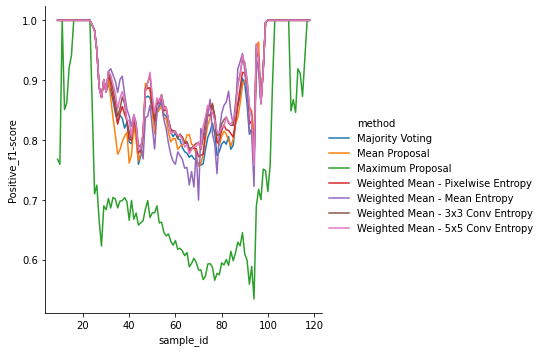

In [16]:
sns.relplot(data=filtered, x='sample_id', y='Positive_f1-score', hue='method', kind='line')

In [14]:
filtered.columns

Index(['Negative_f1-score', 'Negative_precision', 'Negative_recall',
       'Negative_support', 'Positive_f1-score', 'Positive_precision',
       'Positive_recall', 'Positive_support', 'macro avg_f1-score',
       'macro avg_precision', 'macro avg_recall', 'macro avg_support',
       'micro avg_f1-score', 'micro avg_precision', 'micro avg_recall',
       'micro avg_support', 'weighted avg_f1-score', 'weighted avg_precision',
       'weighted avg_recall', 'weighted avg_support', 'non_consensus_px',
       'method', 'sample_id', 'accuracy'],
      dtype='object')

# Label Aggregation

For each Modality, Aggregate the models corresponding to ET, ED, NCRNET and obtain a prediction for T1, T2, T1c, FLAIR models.

In [ ]:
for (test_or_val, modality), current_dataset in DATABASE.groupby(['dataset', 'modality']):
    temp = current_dataset.drop(columns=['dataset', 'modality', 'model_path'])
    temp = temp.set_index(['patient', 'gt_or_pred', 'output_label'])
    # Aggregations expexts Preds: [Agents, H, W, Labels], GT: [H, W, Labels]
    for patient, patient_samples in temp.groupby(['patient']):
        # Loading slices
        
        GT = list()
        for label in LABELS:
            GT.append([np.load(path) for path in patient_samples.loc[patient, 'GT', label]['slice_path']])
        GT = np.concatenate(GT, axis=-1)# Now GT is [Slices, H, W, Label]
    
        PREDS = list()
        for label in LABELS:
            PREDS.append([np.load(path) for path in patient_samples.loc[patient, 'predictions', label]['slice_path']])
        PREDS = np.concatenate(PREDS, axis=-1)# Now PREDS is [Slices, H, W, Label]
        
        
    break

In [100]:
for ds, reg_current_dataset in REGISTRY.groupby('dataset'):
    for modality, reg_current_modality in reg_current_dataset.groupby('modality'):
        CURRENT_AGENTS = reg_current_modality['model'].to_list()
        CURRENT_AGENT_PATHS = reg_current_modality['path'].to_list()
        gt_preds = load_predictions_for_agents(CURRENT_AGENT_PATHS)
        break
    break
    #print(CURRENT_REGISTRY)

In [102]:
for patientid, group in groupby(gt_preds, key=lambda x: x[0]):
    break

In [139]:
FILES_REGISTRY = pd.DataFrame()
extract_patient_key = lambda x: os.path.basename(x).replace('.npy', '').split('_')[0]
extract_slice_id = lambda x: int(os.path.basename(x).replace('.npy', '').split('_')[1])
extract_gt_or_pred = lambda x: os.path.dirname(x).split('/')[-1]

counter = 0
for _, row in REGISTRY.iterrows():
    file_paths = glob.glob(os.path.join(row['path'], '*', '*.npy'))
    print("Inspecting: {}".format(row.path))
    for slice_file in file_paths:
        FILES_REGISTRY = FILES_REGISTRY.append({'dataset': row.dataset,
                                                'modality':row.modality,
                                                'output_label':row.output_label,
                                                'patient':extract_patient_key(slice_file),
                                                'slice':extract_slice_id(slice_file),
                                                'gt_or_pred': extract_gt_or_pred(slice_file),
                                                'model_path':row.path,
                                                'slice_path':slice_file
                                               }, ignore_index=True)
        counter +=1
        print("\rFound {} files".format(counter), end="")
FILES_REGISTRY.to_csv(PREDICTION_FOLDER+'database.csv')
print("Done")

Inspecting: ../../DeepMRI/src/predictions/brats2019v2_validation_crop_mri/Segan_IO_TF2_brats2019v2_t1_ET
Found 12544 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_testing_crop_mri/Segan_IO_TF2_brats2019v2_t1_ET
Found 27648 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_validation_crop_mri/Segan_IO_TF2_brats2019v2_t1_ED
Found 40192 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_testing_crop_mri/Segan_IO_TF2_brats2019v2_t1_ED
Found 55296 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_validation_crop_mri/Segan_IO_TF2_brats2019v2_t1_NCRNET
Found 67840 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_testing_crop_mri/Segan_IO_TF2_brats2019v2_t1_NCRNET
Found 82944 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_validation_crop_mri/Segan_IO_TF2_brats2019v2_t1ce_ET
Found 95488 filesInspecting: ../../DeepMRI/src/predictions/brats2019v2_testing_crop_mri/Segan_IO_TF2_brats2019v2_t1ce_ET
Found 110592 filesInspecting: ../../DeepM

KeyboardInterrupt: 

,dice_score_0,precision_0,sensitivity_0,loss_g,loss_d,learning_rate_g,learning_rate_d,dice_score_complete_tumor_2019,precision_complete_tumor_2019,sensitivity_complete_tumor_2019,...,sensitivity_tumor_core,dice_score_enhancing_tumor,precision_enhancing_tumor,sensitivity_enhancing_tumor,epoch,modality,output_label,dataset,model,path
12,0.069454,0.311591,0.055003,1.109571,-0.135335,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,ET,validation,Segan_IO_TF2_brats2019v2_t2_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
14,0.502437,0.499792,0.562399,0.478645,-0.101765,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,ED,validation,Segan_IO_TF2_brats2019v2_t2_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
16,0.363567,0.340599,0.587381,0.495309,-0.159174,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t2_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...


In [24]:
testgt = np.load(glob.glob(os.path.join(CURRENT_REGISTRY.iloc[0]['path'], 'GT', '*'))[0])

In [17]:
os.path.join(CURRENT_REGISTRY.iloc[0]['path'], 'GT', '*')

'../../DeepMRI/src/predictions/brats2019v2_validation_crop_mri/GT/*'

In [13]:
CURRENT_REGISTRY

,dice_score_0,precision_0,sensitivity_0,loss_g,loss_d,learning_rate_g,learning_rate_d,dice_score_complete_tumor_2019,precision_complete_tumor_2019,sensitivity_complete_tumor_2019,...,sensitivity_tumor_core,dice_score_enhancing_tumor,precision_enhancing_tumor,sensitivity_enhancing_tumor,epoch,modality,output_label,dataset,model,path
0,0.037172,0.186044,0.025208,1.091709,-0.109554,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1,ET,validation,Segan_IO_TF2_brats2019v2_t1_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
2,0.346435,0.326801,0.465659,0.675938,-0.208894,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1,ED,validation,Segan_IO_TF2_brats2019v2_t1_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
4,0.297623,0.276688,0.542862,0.439425,-0.079310,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t1_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...
6,0.455199,0.626057,0.526583,0.345372,-0.106739,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1ce,ET,validation,Segan_IO_TF2_brats2019v2_t1ce_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
8,0.363539,0.417176,0.411383,0.586883,-0.150822,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1ce,ED,validation,Segan_IO_TF2_brats2019v2_t1ce_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
10,0.442890,0.540454,0.470061,0.367990,-0.080527,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1ce,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t1ce_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...
12,0.069454,0.311591,0.055003,1.109571,-0.135335,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,ET,validation,Segan_IO_TF2_brats2019v2_t2_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
14,0.502437,0.499792,0.562399,0.478645,-0.101765,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,ED,validation,Segan_IO_TF2_brats2019v2_t2_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
16,0.363567,0.340599,0.587381,0.495309,-0.159174,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t2_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...
18,0.178700,0.290764,0.189990,1.404254,-1.069956,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,flair,ET,validation,Segan_IO_TF2_brats2019v2_flair_ET,../../DeepMRI/src/predictions/brats2019v2_vali...


(160, 160, 1)

In [7]:
CURRENT_REGISTRY

,dice_score_0,precision_0,sensitivity_0,loss_g,loss_d,learning_rate_g,learning_rate_d,dice_score_complete_tumor_2019,precision_complete_tumor_2019,sensitivity_complete_tumor_2019,...,sensitivity_tumor_core,dice_score_enhancing_tumor,precision_enhancing_tumor,sensitivity_enhancing_tumor,epoch,modality,output_label,dataset,model,path
0,0.037172,0.186044,0.025208,1.091709,-0.109554,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1,ET,validation,Segan_IO_TF2_brats2019v2_t1_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
2,0.346435,0.326801,0.465659,0.675938,-0.208894,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1,ED,validation,Segan_IO_TF2_brats2019v2_t1_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
4,0.297623,0.276688,0.542862,0.439425,-0.079310,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t1_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...
6,0.455199,0.626057,0.526583,0.345372,-0.106739,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1ce,ET,validation,Segan_IO_TF2_brats2019v2_t1ce_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
8,0.363539,0.417176,0.411383,0.586883,-0.150822,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1ce,ED,validation,Segan_IO_TF2_brats2019v2_t1ce_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
10,0.442890,0.540454,0.470061,0.367990,-0.080527,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t1ce,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t1ce_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...
12,0.069454,0.311591,0.055003,1.109571,-0.135335,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,ET,validation,Segan_IO_TF2_brats2019v2_t2_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
14,0.502437,0.499792,0.562399,0.478645,-0.101765,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,ED,validation,Segan_IO_TF2_brats2019v2_t2_ED,../../DeepMRI/src/predictions/brats2019v2_vali...
16,0.363567,0.340599,0.587381,0.495309,-0.159174,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,t2,NCR/NET,validation,Segan_IO_TF2_brats2019v2_t2_NCRNET,../../DeepMRI/src/predictions/brats2019v2_vali...
18,0.178700,0.290764,0.189990,1.404254,-1.069956,0.00002,0.00002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,flair,ET,validation,Segan_IO_TF2_brats2019v2_flair_ET,../../DeepMRI/src/predictions/brats2019v2_vali...
